In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (10,6)
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster", style="ticks")
import ipywidgets
import yt

import glob
import os
import warnings
import h5py

import numpy as np
import pandas as pd

from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    get_snapshot_filenames, \
    snapshot_filename_to_number, \
    total_mass_of_snapshot, \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    total_kinetic_energy_of_snapshot, \
    total_internal_energy_of_snapshot, \
    load_snapshots, \
    plot_projected_density, \
    plot_sliced_field, \
    plot_phase_diagram, \
    field_type, \
    plot_profile, \
    yt_plot_saver, \
    mpl_plot_saver, \
    load_ds_from_ts, \
    RunSummary

import MHD
    
from sql_helpers import add_simulation, \
    open_as_DataFrame

%load_ext autoreload
%autoreload 2

`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 1.0 M_solar
    length : 1.0 pc
    time   : 1.0 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'
`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 8.41e-58 M_solar
    length : 3.24e-19 pc
    time   : 3.17e-14 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [2]:
# run_name = "cluster"
# run_name = "cluster_cooling"
# run_name = "cluster_cooling_100"
# run_name = "cluster_cooling_150"
# run_name = "cluster_cooling_200"
# run_name = "cluster_cooling_mhd_200"
# run_name = "cluster_cooling_mhd_small_200"
run_name = "cluster_cooling_mhd_large_200"
# run_name = "cluster_cooling_250"
# run_name = "cluster_cooling_300"
# run_name = "cluster_cooling_400"
# run_name = "cluster_cooling_small_300"
# run_name = "cluster_cooling_600"
# run_name = "single"
# run_name = "single_cooling"
# run_name = "double"
# run_name = "double_cooling"

run_dir = os.path.join(os.path.pardir, "runs", run_name)

inputs_dir  = os.path.join(run_dir, "inputs")
outputs_dir = os.path.join(run_dir, "outputs")

plots_dir = os.path.join(outputs_dir, "plots")
if not os.path.exists(plots_dir):
    print("making plots_dir")
    os.mkdir(plots_dir)

In [3]:
run_names = [
    "cluster_cooling_100",
    "cluster_cooling_200",
    "cluster_cooling_400",
    "cluster_cooling_mhd_large_200"
]

In [4]:
title_map = {
    "1D" : "1D_06_HD",
    "cluster_cooling_400" :  "3D_10_HD",
    "cluster_cooling_200" :  "3D_20_HD",
    "cluster_cooling_100" :  "3D_40_HD",
    "cluster_cooling_mhd_large_200" :  "3D_20_MHD",
}

In [5]:
dfs = [None]*len(run_names)
for i, run_name in enumerate(run_names):
    add_simulation(run_name, verbose=False)

    df = open_as_DataFrame(run_name)
    
    dfs[i] = df

In [6]:
SNe = get_SNe(inputs_dir)
SN_times           = np.array([SN.time          for SN in SNe])
SN_ejecta_masses   = np.array([SN.ejecta_mass   for SN in SNe])
SN_ejecta_masses_Z = np.array([SN.ejecta_mass_Z for SN in SNe])

In [7]:
dfs_energy = [None]*len(dfs)

for i, run_name in enumerate(run_names):
    outputs_dir = "../runs/{}/outputs".format(run_name)
    energies = np.loadtxt(os.path.join(outputs_dir, "energy.txt"), ndmin=2)
    
    times_statistics    = energies[:,0] * Myr
    thermal_energies    = energies[:,1] * M_solar * (pc/Myr)**2
    potential_energies  = energies[:,2] * M_solar * (pc/Myr)**2
    kinetic_energies    = energies[:,3] * M_solar * (pc/Myr)**2

    times_statistics    = times_statistics / Myr
    thermal_energies    = thermal_energies
    potential_energies  = potential_energies
    kinetic_energies    = kinetic_energies
    
    df_energy_tmp = pd.DataFrame(data={
        "time"  : times_statistics,
        "E_int" : thermal_energies,
        "E_kin" : kinetic_energies,
        "E_tot" : thermal_energies + kinetic_energies,
        
    })
    
    df_energy_tmp = df_energy_tmp[["time", "E_int", "E_kin", "E_tot"]]

    
    dfs_energy[i] = df_energy_tmp


In [8]:
dfs_energy[0].head()

,time,E_int,E_kin,E_tot
0,0.000000,4.938177e+50,0.000000e+00,4.938177e+50
1,0.001000,1.493504e+51,0.000000e+00,1.493504e+51
2,0.001000,1.493505e+51,0.000000e+00,1.493505e+51
3,0.011153,1.244959e+51,2.218132e+50,1.466773e+51
4,0.021306,1.130093e+51,2.245737e+50,1.354666e+51


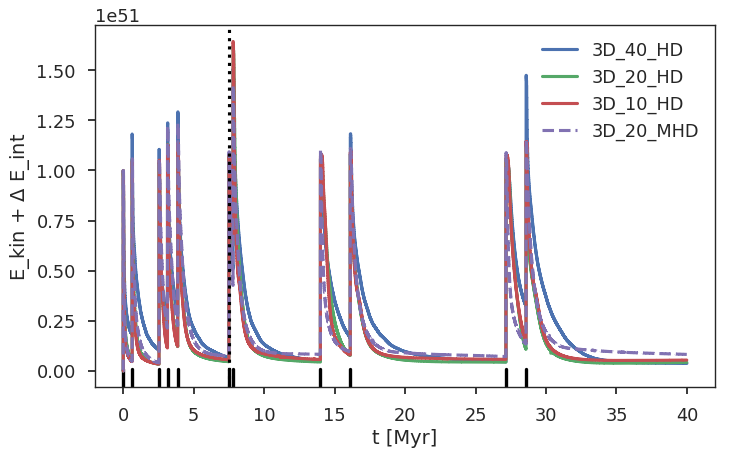

In [9]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]

    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid", linestyle=linestyle)

plt.xlabel("t [Myr]")
plt.ylabel("E_kin + $\Delta$ E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
# plt.xlim(10,15)

(-6.0043985675265733e+49, 1.6e+51)

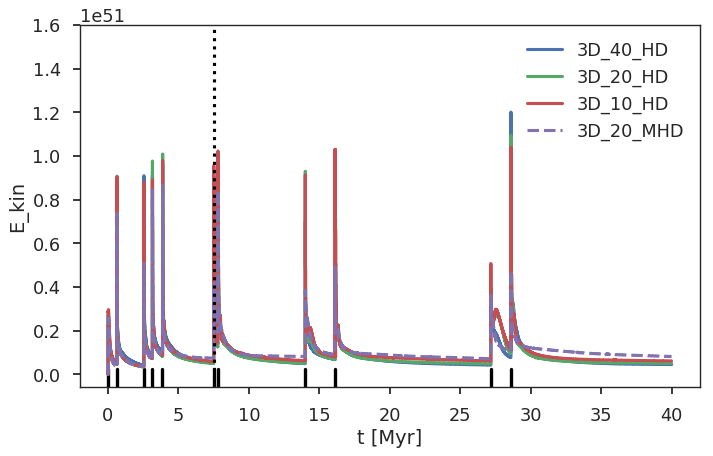

In [10]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_kin = df_energy.E_kin - df_energy.E_kin[0]
    
    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"
    
    plt.plot(df_energy.time, E_kin , label=title_map[run_names[i]],
             drawstyle="steps-mid", linestyle=linestyle)
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.ylim(top=1.6e51)

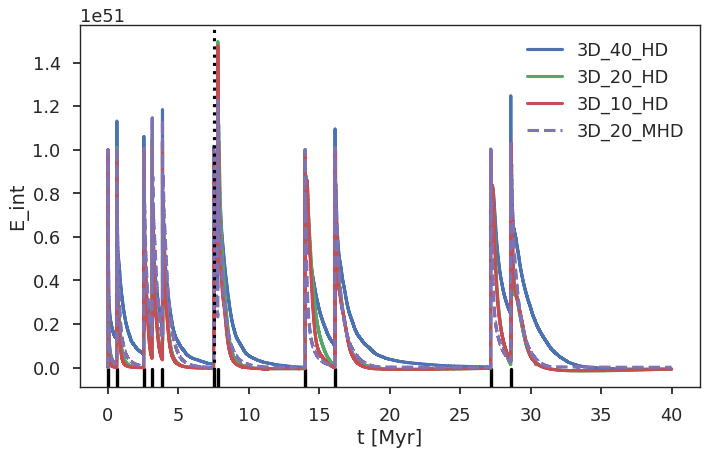

In [11]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_int = df_energy.E_int - df_energy.E_int[0]
    
    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"    
    
    plt.plot(df_energy.time, E_int , label=title_map[run_names[i]],
             drawstyle="steps-mid", linestyle=linestyle)
    
plt.xlabel("t [Myr]")
plt.ylabel("E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
# plt.xlim(10,15)

(7.45, 7.6)

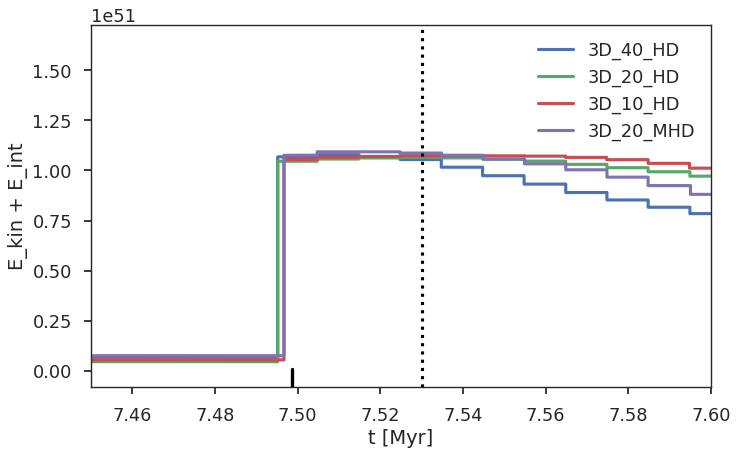

In [12]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(7.45,7.6)

(7.45, 7.81)

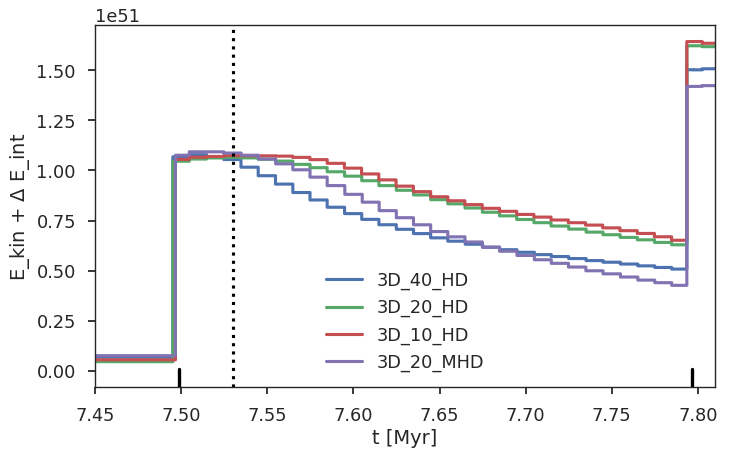

In [13]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + $\Delta$ E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(7.45, 7.81)

(7.45, 7.81)

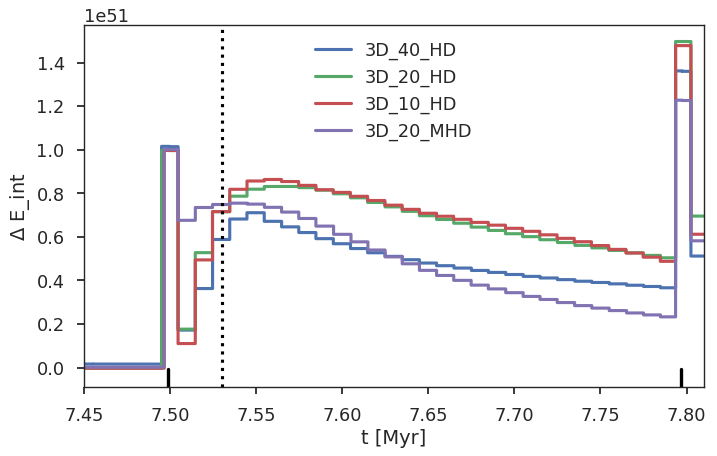

In [14]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_int = df_energy.E_int - df_energy.E_int[0]
    
    plt.plot(df_energy.time, E_int , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("$\Delta$ E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(7.45, 7.81)

3D_40_HD: min(t_cool) = 0.16 at time 7.5699
3D_20_HD: min(t_cool) = 0.30 at time 7.64992
3D_10_HD: min(t_cool) = 0.24 at time 7.62984
3D_20_MHD: min(t_cool) = 0.13 at time 7.61987


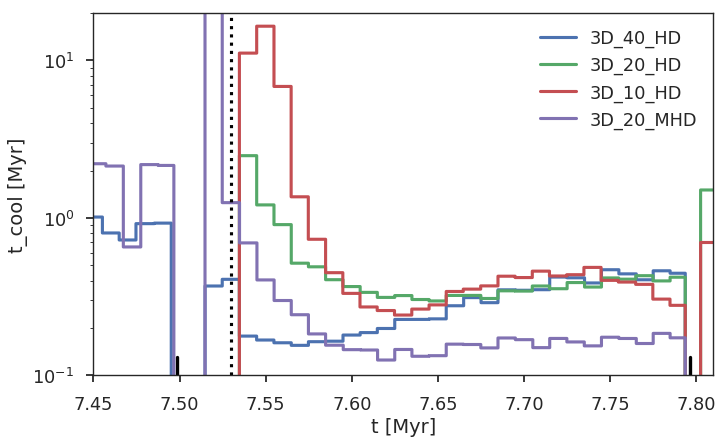

In [15]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    E_int = df_energy.E_int - df_energy.E_int[0]
    
    dE_tot = E_tot.diff() / df_energy.time.diff()
    
    t_cool = -E_int / dE_tot
    
    plt.plot(df_energy.time, t_cool , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
    mask = (df_energy.time > 7.55) & (df_energy.time < 7.75) & (t_cool > .01)
    print("{}: min(t_cool) = {:.2f} at time {}".format(
            title_map[run_names[i]], 
            min(t_cool[mask]),
            (df_energy.time[mask])[np.argmin(t_cool[mask])]
    )
         )
    
plt.xlabel("t [Myr]")
plt.ylabel("t_cool [Myr]")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(7.45, 7.81)

# plt.ylim(-1e51, 1e51)
plt.ylim(.1, 20)
plt.yscale("log")



## 1D interlude

In [16]:
run_summary_hi_res = RunSummary("1D_data-high_time_res/",
                                "F5509BF1-3F9E-4008-B795-0482ECED199B")

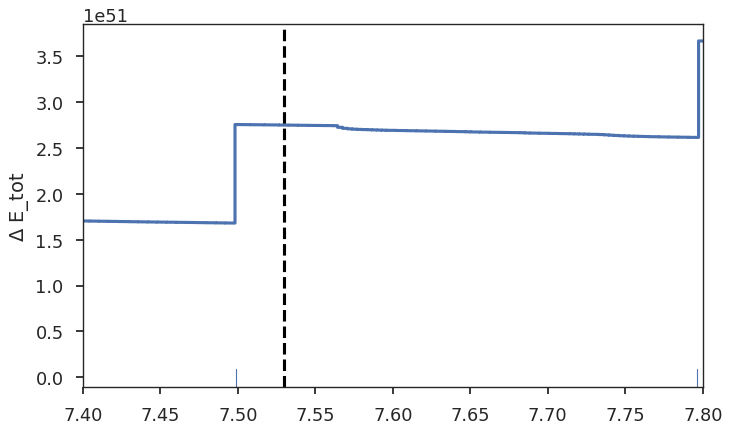

In [17]:
plt.plot((run_summary_hi_res.times - run_summary_hi_res.times[0])/Myr, 
         run_summary_hi_res.E_tot - run_summary_hi_res.E_tot[0]+ 1e51,
        drawstyle="steps-mid")

sns.rugplot((run_summary_hi_res.overview.SNe_times - run_summary_hi_res.times[0])/Myr)
plt.xlim(7.4, 7.8)

plt.axvline(7.53, linestyle="dashed", color="black")

plt.ylabel(r"$\Delta$ E_tot")

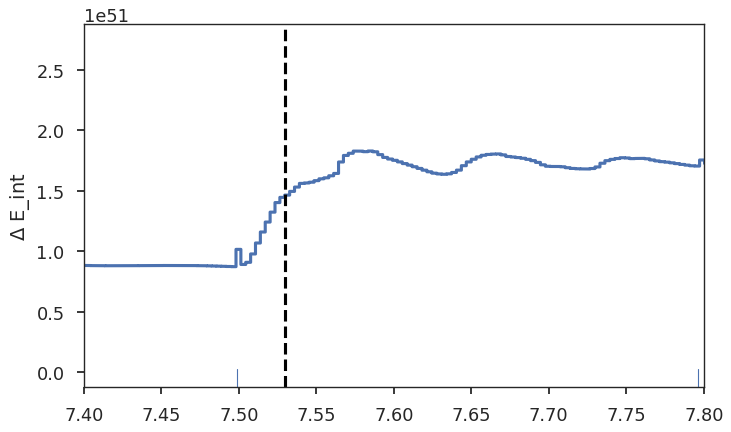

In [18]:
plt.plot((run_summary_hi_res.times - run_summary_hi_res.times[0])/Myr, 
         run_summary_hi_res.E_int - run_summary_hi_res.E_int[0]+ 1e51,
        drawstyle="steps-mid")

sns.rugplot((run_summary_hi_res.overview.SNe_times-run_summary_hi_res.times[0])/Myr)
plt.xlim(7.4, 7.8)

plt.axvline(7.53, linestyle="dashed", color="black")

plt.ylabel(r"$\Delta$ E_int")

min cooling time of 0.57 at t=11.60


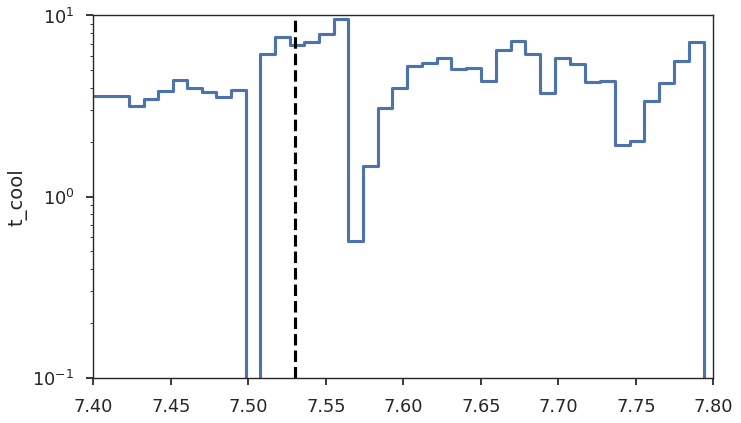

In [19]:
## down sample to be a more fair comparison with the 3D data
# otherwise you can get a brief blip with a very low cooling time
# but which isn't dynamically relevant.
smooth_factor=3
times = run_summary_hi_res.times[::smooth_factor]
E_int = run_summary_hi_res.E_int[::smooth_factor]
E_tot = run_summary_hi_res.E_tot[::smooth_factor]


dE_dt = np.concatenate([[np.inf], np.diff(E_tot) / np.diff(times)])
dE_int = E_int - E_int[0] + 1e51
t_cool = - dE_int / dE_dt

mask = (t_cool > .1) & ((times/Myr) > 11.54) & ((times/Myr) < 11.65)
print("min cooling time of {:.2f} at t={:.2f}".format(
    t_cool[mask].min() / Myr,
    times[mask][np.argmin(t_cool[mask])] / Myr,
))

plt.plot((times - run_summary_hi_res.times[0]) / Myr,
         t_cool / Myr,
         drawstyle="steps-mid",)

plt.xlim(7.4, 7.8)

plt.axvline(7.53, linestyle="dashed", color="black")

plt.ylim(.1, 10)
plt.yscale("log")


plt.ylabel(r"t_cool")

## Back to 3D
An unorganized look at some other SNe

(27.1, 27.5)

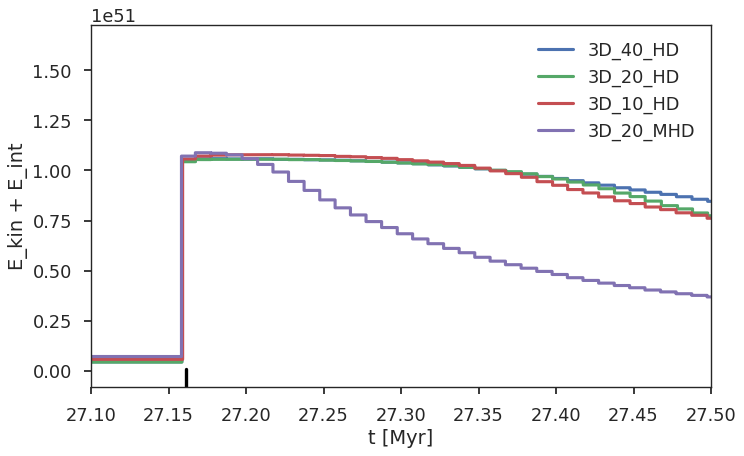

In [14]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(27.1,27.5)

(25, 30)

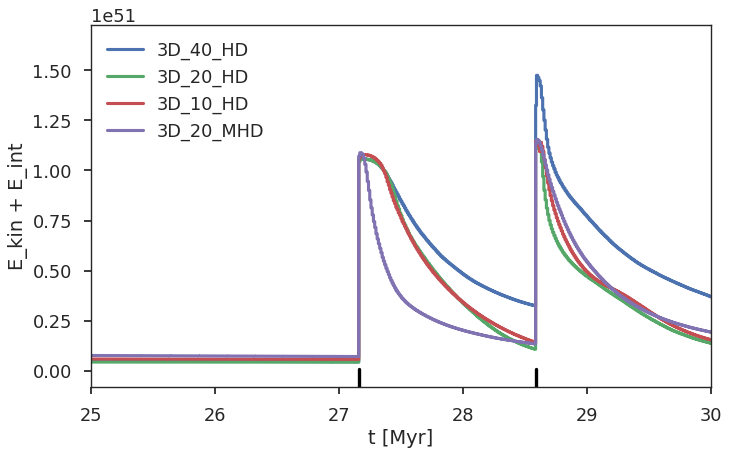

In [15]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=title_map[run_names[i]],
             drawstyle="steps-mid")
    
plt.xlabel("t [Myr]")
plt.ylabel("E_kin + E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(25,30)

(13.95, 14.1)

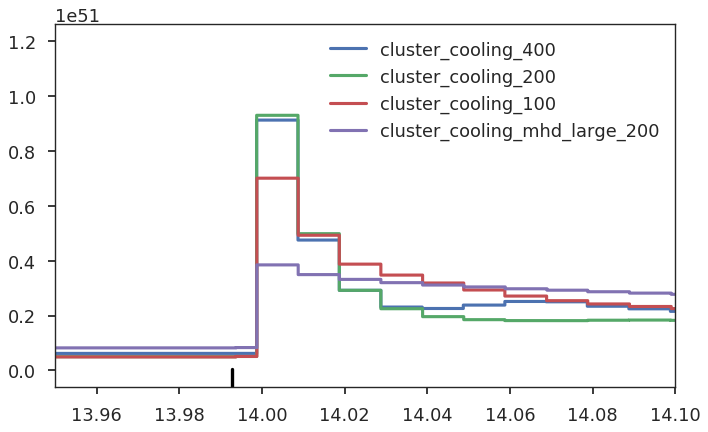

In [55]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_kin - df_energy.E_kin[0]
    
    plt.plot(df_energy.time, E_tot , label=run_names[i],
             drawstyle="steps-mid")
    

plt.axvline(14.417492, linestyle="dashed", color="black")
plt.legend(loc="best")
    
plt.xlim(13.95,14.1)